# Метод статистической деконволюции

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from random import random

In [2]:
from modules import randomized_ir, utils, plots

In [10]:
SAVE_IMAGES = True

In [11]:
from importlib import reload

def reload_modules():
    reload(randomized_ir)
    reload(utils)
    reload(plots)

In [12]:
reload_modules()

## IR

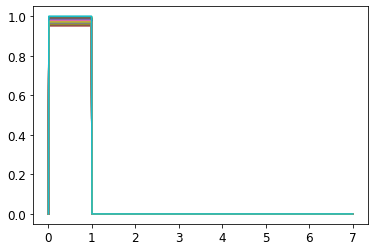

In [13]:
gamma = 0.5

pts_per_bin = 100
L_true = 7

ir_x = np.linspace(0, L_true, int(L_true * pts_per_bin))

# exp-decay
# ir_y = np.exp(- gamma * ir_x)

# step
step_width = 1
step_start = 0
ir_y = (np.logical_and(ir_x > step_start, ir_x <= step_start+step_width)).astype('float')

# gaussian shape
# x_max = 1
# x_sigma = 4
# ir_y = np.exp(- (ir_x - x_max) ** 2 / (2 * x_sigma ** 2))

factor_min, factor_max = 0.95, 1
rir = randomized_ir.RandomizedIr(ir_x, ir_y, factor=lambda: factor_min + random()*(factor_max - factor_min))
# rir = rir.RandomizedIr(ir_x, ir_y)

rir.plot_realizations(count=30)

# Convoluted signal

Pic: `\ref{pic:problem-setup}`


In [14]:
N = 50
n_vec_mean = 15

n_vec = utils.generate_poissonian_ns(n_vec_mean, N)

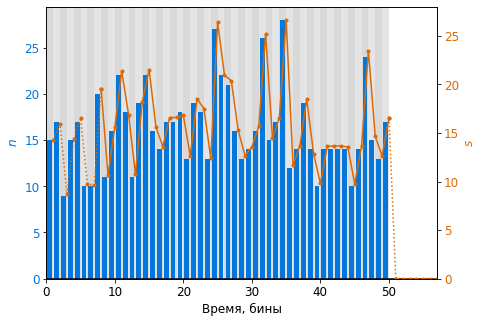

In [15]:
# uniform inbin time distribution:
s_vec = rir.convolve_with_n_vec(n_vec)

# non trivial inbin time distribution:
# S_vec = rir.convolve_with_n_vec(n_vec, inbin_invcdf=lambda x: x**(1/10), debug_inbin_times=True)

filename = 'problem-setup-example' if SAVE_IMAGES else None

plots.plot_convolution(n_vec, s_vec, filename=filename)

# Mean-based estimation

Chapter: `Грубая оценка методом наименьших квадратов`

In [17]:
stats = randomized_ir.RandomizedIrStats(rir, samplesize=100000)

n_vec_estimation = stats.estimate_n_vec(s_vec, debug=True)

Mean RIR:
[0.967 0.    0.    0.    0.    0.    0.    0.   ]

Before cutting edge effects:
[[0.967 0.    0.    ... 0.    0.    0.   ]
 [0.    0.967 0.    ... 0.    0.    0.   ]
 [0.    0.    0.967 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]

After cutting edge effects:
[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.967 0.    0.   ]
 [0.    0.    0.    ... 0.    0.967 0.   ]
 [0.    0.    0.    ... 0.    0.    0.967]]


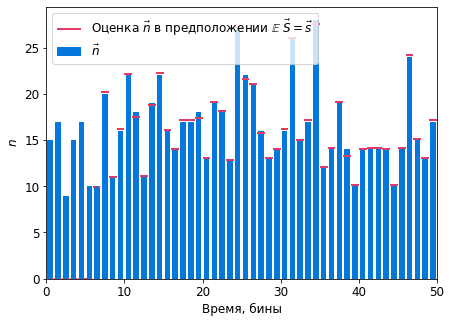

In [18]:
filename = 'mean-estimation' if SAVE_IMAGES else None
plots.plot_mean_n_estimation(n_vec, n_vec_estimation, stats.L, filename=filename)

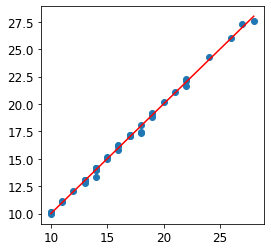

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))

cut_n_vec = utils.slice_edge_effects(n_vec, stats.L, N)
cut_n_vec_estimation = utils.slice_edge_effects(n_vec_estimation, stats.L, N)

ax.scatter(cut_n_vec, cut_n_vec_estimation)

n_minmax = np.linspace(cut_n_vec.min(), cut_n_vec.max(), 2)
ax.plot(n_minmax, n_minmax, 'r-')

plt.show()

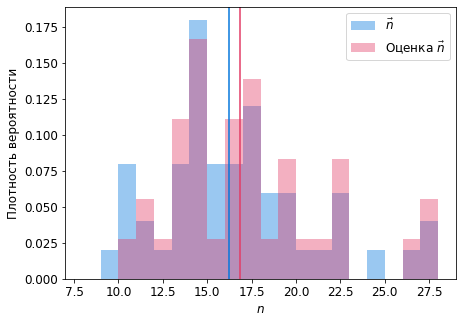

In [20]:
# filename = 'mean-estimation-assessment'
filename = None
plots.plot_mean_n_estimation_assessment(n_vec, n_vec_estimation, L=stats.L, filename=filename)

# MCMC-based estimation

Assuming $S_j$ are close to normal

In [21]:
loglike = stats.get_loglikelihood_normdist(s_vec)

loglike(n_vec_estimation)

-inf

In [22]:
# see https://emcee.readthedocs.io/en/stable/user/sampler/

import emcee

rng = np.random.default_rng()

n_walkers = 128

spread_from_estimation = 3  # from n_vec_estimation
n_starting_points = np.tile(n_vec_estimation, (n_walkers, 1)) + rng.normal(scale=spread_from_estimation, size=(n_walkers, N))

sampler = emcee.EnsembleSampler(n_walkers, N, loglike)

In [23]:
sampler.run_mcmc(n_starting_points, 50000)

print('done!')

/home/njvh/Documents/Science/sphere/thesis/thenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
done!


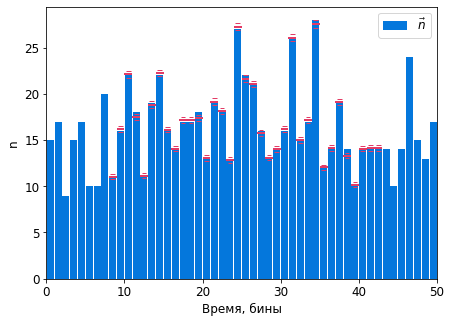

In [26]:
sample = sampler.get_chain(flat=True, discard=20000, thin=5)

plots.plot_bayesian_mean_estimation(n_vec, sample, stats.L)

Text(0.5, 0, 'n')

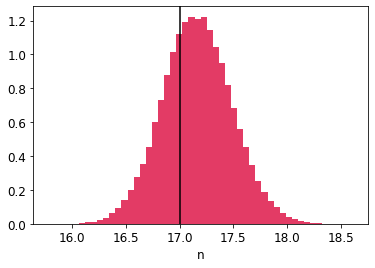

In [27]:
fig, ax =  plt.subplots()

ibin = 18

ax.hist(sample[:, ibin], bins=50, density=True, color='#e33b65')
ax.axvline(n_vec[ibin], color='black')

ax.set_xlabel('n')